In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import HashingVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

---
#Stochastic Gradient Descent
---

####SGDClassifier(), and SGDRegressor()
- have both a .fit() method and a .partial_fit() method. The latter for use with batches
- partial_fit() requires the declaration of the classes with the method. The algorithm needs to know in advance all the class codes that it expects to see during training
- The loss paramters determines the modelling algorithm type. Loss can take the following values to allow for the following algorithms:
1. loss - logistic regression
2. hinge - linear support vector machine

- SGDRegressor mimics linear regression using the squared_loss loss parameter. The huber loss transforms the squared loss into a linear loss over a certain distance, epsilon. It can also act as a linear SVM (regression) using the epsilon_insensitive loss, or squared_epsilon_insensitive (which penalizes outliers more)

- Performance of different loss functions cannot be estimated a priori.

- If doing classification and you need an estimation of class probabilities you will be limited in your choice to log or modified_huber only

#####Other key Parameters:
- n_iter: the number of iterations over the data
- penalty: L1, L2, or elasticnet
- alpha: regularization term. Higher means more regularization
- L1 ratio: only used with elasticnet penalty to set the balance between L1 and L2 
- learning_rate: Usually invscaling for regression. If you want to use invscaling for classification, set eta0 and power_t (invscaling = eta0/(t**power_t). With invscaling you can start with a lower learning rate, which is less than the optimal rate, but it will decrease more slowly
- epsilon: only use if your loss is huber, epsilon_insensitive ro squared_epsilon_insensitive
- shuffle: if True the algorithm will shuffle the training data order

fetch_20newsgroups - containing 11314 posts, with about 200 words in each post

#####Get the 20 news groups dataset

In [2]:
ngd = fetch_20newsgroups(shuffle = True, remove = ("headers", "footers", "quotes"), random_state = 6)

In [3]:
print np.shape((ngd.data))
np.mean([len(text.split(' ')) for text in ngd.data])

(11314,)


206.15980201520242

In [4]:
#X, y = make_classification(n_samples = 10**5, n_features = 5, n_informative = 3, random_state = 65)
#print X.shape, y.shape
#Data1 = np.c_[y, X]
#np.savetxt('data1.csv', Data1, delimiter=",")
#del (Data1, X, y)

In [5]:
#X, y = make_classification(n_samples = 10**6, n_features = 5, n_informative = 3, random_state = 67)
#print X.shape, y.shape
#Data1 = np.c_[y, X]
#np.savetxt('data2.csv', Data1, delimiter=",")
#del (Data1, X, y)

#####Using make_classification make a dataset with 10**7 samples and 5 features

In [6]:
X, y = make_classification(n_samples = 10**7, n_features = 5, n_informative = 3, random_state = 67)
print X.shape, y.shape
Data1 = np.c_[y, X]
np.savetxt('data3.csv', Data1, delimiter=",")
#del (Data1, X, y)

(10000000, 5) (10000000,)


In [69]:
#!lsA

---
#Scalability with Volume
---

###Strategies to manage high volumes of data without loading it all into memory:
- incrementally update the parameters of your algorithm until all the observations have been elaborated at least once
- partial_fit() method which can be applied to a certain number of supervised and unsupervised algorithms
- incremental learning: feed in chunks or batches of data to start fitting your model as soon as data arrives
- incremental learning is about:
1. Batch size - this is usually memory depdendent. In general the larger the better
2. Data preprocessing - feature scaling can be extremely difficult, because ahead of time you don't know the range of your data. You either complete data collection and then re-scale, or you estimate the range of the features, scale on the fly and discard any obesrvations that exceed the anticipated range
3. Number and passes through the data required (or not) - in general it is hard, if not possible to make more than one pass through the data. Data order is also very important. Stochastic Gradient Descent prefers shuffled dataa
4. Validation and hyper-parameter tuning - more difficult than normal. Either validate in a progressive way, or hold out some observations from every chunk/batch.


#####read_csv allows iteration over the file by reading batches or chunks of 10000 observations (in this case)
#####MinMaxScaler is used to range the data after the first batch becomes available, after this batches are trimmed, so no values exceed or fall below the min/max values set

#####Now run through the file by chunking the stream coming from the file

In [7]:
stream = pd.read_csv("data3.csv", header = None, chunksize = 10000)

AttributeError: 'TextFileReader' object has no attribute 'head'

In [8]:
minmax = MinMaxScaler(feature_range = (0, 1))

In [9]:
clf = SGDClassifier(loss = 'log', alpha = 0.001, random_state = 98)

acc_list = []

for n, chunk in enumerate(stream):
    if n == 0:
        minmax.fit(chunk.ix[:, 1:].values)
    X = minmax.transform(chunk.ix[:, 1:].values)
    X[X>1] = 1
    X[X<0] = 0
    y = chunk.ix[:, 0]
    if n > 1:
        acc_list.append(clf.score(X, y))
    clf.partial_fit(X, y, classes = np.unique(y))
    p = n
print p
print len(acc_list)
print np.mean(acc_list)

999
998
0.895329859719


In [42]:
print X[:1,:]
#print y[:]

[[ 0.65609732  0.36011718  0.49704438  0.51682995  0.52553027]]


In [43]:
clf.predict([0.65, 0.36, 0.49, 0.51, 0.52])

array([ 1.])

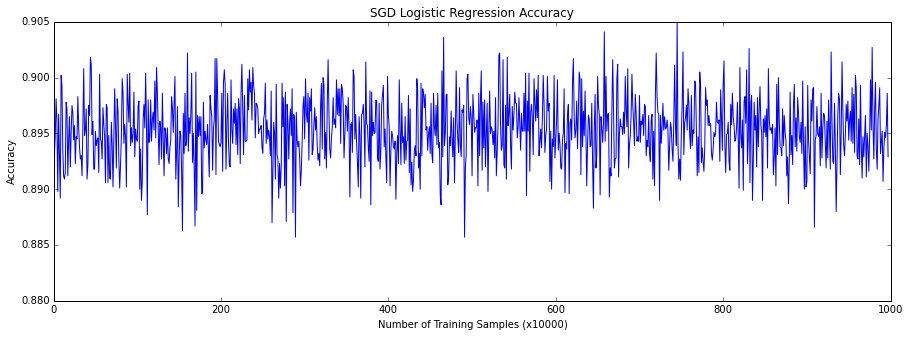

In [45]:
fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)
ax.plot(acc_list)
ax.set_title("SGD Logistic Regression Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of Training Samples (x10000)")

---
##Algorithm Choices offering Partial Fit

###- MultinomialNB
###- BernoulliNB
###- SGDClassifier
###- SGDRegressor


- smaller batches tend to be slower, because usually the bottleneck for these things is disk access or data access

#####Handling data variability using hashing
- hash functions map, in a deterministic way, using any input they receive, whether is be numerical or string input
- they return an integer within a certain range
- hashing is extremely fast and efficient

#####Sparse matrices
- as we have already seen, sparse matrices only hold non-zero values
- a sparse matrix has a default value of zero

####hashing therefore bounds every input, to a certain range, or position onto a corresponding sparse matrix

In [10]:
print np.unique(ngd.target)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [11]:
def stream_text():
    for y, X in zip(ngd.target, ngd.data):
        yield y, X

In [12]:
my_hash = HashingVectorizer(stop_words = 'english', norm = 'l2', non_negative = True)
clf = SGDClassifier(loss= 'log', alpha = 0.0001, random_state = 98)

In [13]:
texts = []
targets = []

for n, (target, text) in enumerate(stream_text()):
    texts.append(text)
    targets.append(target)
    if (n % 1000 == 0) and (n > 0):
        batch = my_hash.transform(texts)
        if n > 1000:
            last_validation_score = clf.score(batch, targets)
        clf.partial_fit(batch, targets, classes = np.unique(ngd.target))
        texts = []
        targets = []

print last_validation_score

0.707


In [14]:
new_text_A = [' A 2014 red Toyota Prius v Five with fewer than 14K miles. \
Powered by a reliable 1.8L four cylinder hybrid engine that averages 44mpg in the city and 40mpg on the highway.']

new_text_B = ['There always seems to be something unusual about the political class.\
The GOP and Democrats are poles apart in ideology']

N-

new_text_vector = my_hash.transform(new_text_B)

yhat = clf.predict(new_text_vector)
print ngd.target_names[yhat]

SyntaxError: invalid syntax (<ipython-input-14-b4ca209a123f>, line 5)